In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [87]:
def ejd(N_max, poi, mode):
    
    if(mode == 'min'):
        poi[1, :] = poi[1, ::-1]
        supp = [(0, N_max)]
    else:
        supp = [(0, 0)]
    
    cdf = np.ndarray((2, N_max + 1))
    for i in range(2):
        cdf[i, 0] = poi[i, 0]
        for j in range(1, N_max + 1):
            cdf[i, j] = cdf[i, j - 1] + poi[i, j]
    
    
    z = min(cdf[0][0], cdf[1][0])
    prob = [z]
    ptr = [0, 0]
    ev = 0
    
    while (ptr[0] < N_max or ptr[1] < N_max):
        if (ptr[1] == N_max or (ptr[0] < N_max and \
                cdf[0][ptr[0]] < cdf[1][ptr[1]])):
            ptr[0] = ptr[0] + 1
        else:
            ptr[1] = ptr[1] + 1
        
        old_z = z
        z = min(cdf[0][ptr[0]], cdf[1][ptr[1]])
        prob.append(z - old_z)
        
        if(mode == 'min'):
            supp.append((ptr[0], N_max - ptr[1]))
            ev = ev + ptr[0] * (N_max - ptr[1]) * (z - old_z)
        else:
            supp.append((ptr[0], ptr[1]))
            ev = ev + ptr[0] * ptr[1] * (z - old_z)
    
    return supp, prob, ev

In [102]:
def generate_poisson_2d_corr_rv(intensity, corr, T = 10, N_max = 1000):
    
    for i in range(2):
        intensity[i] = intensity[i] * T
    
    
    # Step 1: Generate probability distribution of Poisson
    poi = np.ndarray((2, N_max + 1))
    for i in range(2):
        cur_value = np.exp(-intensity[i])
        poi[i, 0] = cur_value
        for j in range(1, N_max + 1):
            cur_value = cur_value * intensity[i] / j
            poi[i, j] = cur_value
    
    
    # Step 2: Calculate the extreme values of E[N1 N2]
    # First, maximal correlation
    supp_max, prob_max, ev_max = ejd(N_max, poi, mode = 'max')
    # Next, minimal correlation
    supp_min, prob_min, ev_min = ejd(N_max, poi, mode = 'min')
    
    print('Max ev =', ev_max)
    print('Min ev =', ev_min)
    
    
    # Step 3: Draw (n1, n2) ~ (N1, N2) appropriately
    ev_target = intensity[0] * intensity[1] + corr * np.sqrt(intensity[0] * intensity[1])
    
    print('Target ev =', ev_target)
    
    epsilon = 1e-9
    
    if(ev_target < ev_min - epsilon):
        print('Generation failed.')
        return
    elif(ev_target > ev_max + epsilon):
        print('Generation failed.')
        return
    else:
        ratio = (ev_target - ev_min) / (ev_max - ev_min)
        ratio = min(ratio, 1.0)
        ratio = max(ratio, 0.0)
    
    randnum = np.random.uniform(0, 1)
    
    n = [0] * 2
    
    if(randnum < ratio):
        # draw from maximal correlation support
        prob = np.random.uniform(0, 1)
        for i in range(len(supp_max)):
            if prob <= prob_max[i] or i == len(supp_max) - 1:
                (n[0], n[1]) = supp_max[i]
                break
            else:
                prob = prob - prob_max[i]
    else:
        # draw from minimal correlation support
        prob = np.random.uniform(0, 1)
        for i in range(len(supp_min)):
            if prob <= prob_min[i] or i == len(supp_min) - 1:
                (n[0], n[1]) = supp_min[i]
                break
            else:
                prob = prob - prob_min[i]


    # Step 4: Place jumps uniformly in [0, T], then plot
    
    plt.xlim(0, T)
    
    for i in range(2):
        jumps = [0, T + 0.5]
        for j in range(n[i]):
            arrival_time = np.random.uniform(0, T)
            jumps.append(arrival_time)
        
        jumps.sort()
        jumps = np.asarray(jumps)
        plt.step(jumps, np.arange(jumps.size), where = 'post')
        
    plt.legend(['Process 1', 'Process 2'])

In [105]:
generate_poisson_2d_corr_rv(intensity = [2, 2], corr = -1.0)


Max ev = 419.9999999999985
Min ev = 380.19500821286135
Target ev = 380.0
Generation failed.


Max ev = 109.99999999999964
Min ev = 90.20029076026648
Target ev = 91.0


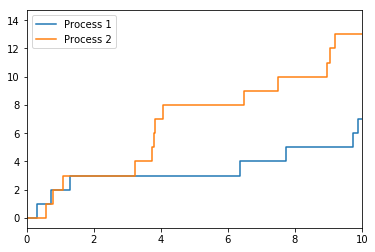

In [107]:
generate_poisson_2d_corr_rv(intensity = [1, 1], corr = -0.9)

Max ev = 214.05203758896366
Min ev = 186.07141746466363
Target ev = 209.89949493661166


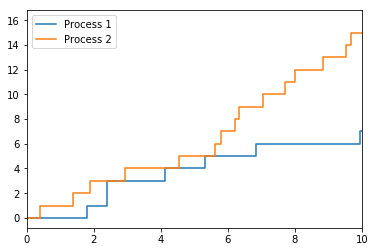

In [108]:
generate_poisson_2d_corr_rv(intensity = [1, 2], corr = 0.7)

Max ev = 522.2290692469525
Min ev = 477.88479162540966
Target ev = 511.180339887499


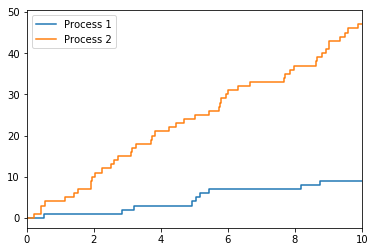

In [109]:
generate_poisson_2d_corr_rv(intensity = [1, 5], corr = 0.5)

Max ev = 109.99999999999964
Min ev = 90.20029076026648
Target ev = 99.9


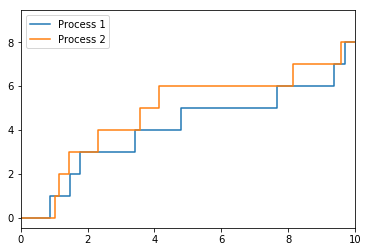

In [110]:
generate_poisson_2d_corr_rv(intensity = [1, 1], corr = -0.01)

In [112]:
generate_poisson_2d_corr_rv(intensity = [3, 6], corr = -1.0)

Max ev = 1842.3340147334188
Min ev = 1757.7777707291382
Target ev = 1757.5735931288073
Generation failed.
